<a href="https://colab.research.google.com/github/jfmaramburo/BEDU_COVID19/blob/main/COVID19_leerMYSQL_MostrarAnalisis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#!pip install mysql.connector
#!pip install -U PyYAML
#Declaración de Imports
import pandas as pd
import mysql.connector
import matplotlib.pyplot as plt
import yaml  
import folium
import seaborn as sns
from scipy import stats
from scipy.stats import skew, kurtosis
import numpy as np
sns.set(style='whitegrid')
from datetime import date
from datetime import datetime
from sklearn.cluster import KMeans

In [4]:
#Lectura de archivo YAML donde se encuentran los datos de conexion a MYSQL
with open("/content/drive/MyDrive/Proyecto BEDU/Pitch/config.yaml", "r") as f:
     params = yaml.load(f, Loader=yaml.FullLoader)

In [5]:
#funcion para obtener los datos de todo mexico o alguna entidad federativa seleccionada
def obtiene_datos(entidad_res):

    if entidad_res == 0:
        query = "select fecha_ingreso, sum(casos) as casos, sexo from casos_global group by fecha_ingreso, sexo"
        descripcion = 'Republica Mexicana'
    else:
        query = "select fecha_ingreso, casos, sexo from casos_global where entidad_res = " + str(entidad_res)

    cnx      = mysql.connector.connect(
    host     = params['host'],
    user     = params['username'],
    password = params['password'],
    port     = params['port'],
    database = params['database'], auth_plugin='mysql_native_password')

    try:
        db_cursor = cnx .cursor()

        db_cursor.execute(query)
        table_rows = db_cursor.fetchall()
        mysql_mexico = pd.DataFrame(table_rows)

        
        diccionario_de_rename= {
            0 : 'FECHA_INGRESO',
            1 : 'CASOS',
            2 : 'SEXO'
        }
    
        diccionario_de_tipos= {
            'CASOS' : 'int',
            'FECHA_INGRESO' : 'string',
            'SEXO' : 'int'
        }

        #Renombra columnas
        mysql_mexico = mysql_mexico.rename(columns=diccionario_de_rename)
    
        #cambiar tipo de dato
        mysql_mexico = mysql_mexico.astype(diccionario_de_tipos)
    
    
        cnx.close()
    except:
        mysql_mexico = "Ocurrio un error en la consulta"
            
    return mysql_mexico


In [6]:
#funcion para obtener el nombre de la entidad federativa seleccionada
def obtiene_nombre(entidad_res):

    if entidad_res == 0:
        mysql_entidad = 'Casos Confirmados de COVID19 en la Republica Mexicana'
    else:
        query = "select entidad_federativa from catalogo_entidades where clave_entidad = " + str(entidad_res)
       
        cnx      = mysql.connector.connect(
        host     = params['host'],
        user     = params['username'],
        password = params['password'],
        port     = params['port'],
        database = params['database'])
        
        try:
            db_cursor = cnx .cursor()

            db_cursor.execute(query)
            table_rows = db_cursor.fetchall()
            mysql_entidad = "Casos Confirmados de COVID19 en " + pd.DataFrame(table_rows).loc[0,0] 

            cnx.close()
    
        except:
            mysql_entidad = "Ocurrio un error en la consulta"
        
        
    return mysql_entidad

In [7]:
#Funcion para Obtener la Suma de Casos de cada Entidad Federativa
def casos_x_estado(sexo):
    
    #query = "select sum(t1.casos), t2.entidad_federativa  from casos_global as t1 inner join catalogo_entidades AS t2  on  t1.ENTIDAD_RES = t2.CLAVE_ENTIDAD where sexo = " + str(sexo) + " group by t1.entidad_res"
    query = "select sum(t1.casos), t2.entidad_federativa, t2.poblacion_mujeres,  t2.poblacion_hombres  from casos_global as t1 inner join catalogo_entidades AS t2  on  t1.ENTIDAD_RES = t2.CLAVE_ENTIDAD where sexo = " + str(sexo) + " group by t2.entidad_federativa, t2.poblacion_mujeres,  t2.poblacion_hombres"

    cnx      = mysql.connector.connect(
    host     = params['host'],
    user     = params['username'],
    password = params['password'],
    port     = params['port'],
    database = params['database'], auth_plugin='mysql_native_password')

    try:
      db_cursor = cnx .cursor()

      db_cursor.execute(query)
      table_rows = db_cursor.fetchall()
      mysql_mexico = pd.DataFrame(table_rows)

      diccionario_de_rename= {
           0 : 'CASOS',
            1 : 'ESTADO',
            2 : 'POBLACION_MUJERES',
            3 : 'POBLACION_HOMBRES'
        }
        
      diccionario_de_tipos= {
            'CASOS' : 'int',
            'ESTADO' : 'string',
            'POBLACION_MUJERES': 'int',
            'POBLACION_HOMBRES': 'int'
        }

        #Renombra columnas
      mysql_mexico = mysql_mexico.rename(columns=diccionario_de_rename)

        #cambiar tipo de dato
      mysql_mexico = mysql_mexico.astype(diccionario_de_tipos)

      cnx.close()
    except:
        mysql_mexico = "Ocurrio un error en la consulta"
            
            
    return mysql_mexico


In [22]:
#Funcion que muestra la Información en base a DF enviado
def analisis_datos(df_consulta):
    
    #Valores Maximos y Minimos
    df1 = df_consulta.groupby(['FECHA_INGRESO'])['CASOS'].sum().reset_index()
    mex_max = df1.sort_values(by ='CASOS', ascending = False).head(1) 
    mex_min = df1.sort_values(by ='CASOS').head(1)


    #Estimados de Locacion:
    media = round(df1['CASOS'].mean(),0)     
    mediana = round(df1['CASOS'].median(),0)
    media_truncada = round(stats.trim_mean(df1['CASOS'], 0.1),0)
    std = df1['CASOS'].std()
        
    #Estimados de Orden      
    print("Día con el Mayor Número de Casos Confirmados es el: " + mex_max.iloc[0, 0] + " con: " + mex_max.iloc[0, 1].astype('str') + " caso(s)")
    print("Día con el Menor Número de Casos Confirmados es el: " + mex_min.iloc[0, 0] + " con: " + mex_min.iloc[0, 1].astype('str') + " caso(s)")
        
    print("----------------Estimados de Locación----------------")
    print("La Media para la entidad seleccionada es: " + repr(media))
    print("La Mediana para la entidad seleccionada es: " + repr(mediana))
    print("La Media Truncada para la entidad seleccionada es: " + repr(media_truncada))
    print("La Desviacion Estandar  para la entidad seleccionada es: " + repr(std))
        
    print("----------------Estadisticos de Orden----------------")
    print("Valor mínimo: " + repr(df1['CASOS'].min()))
    print("Percentil 10: " + repr(df1['CASOS'].quantile(0.1)))
    print("Percentil 25: " + repr(df1['CASOS'].quantile(0.25)))
    print("Percentil 50: " + repr(df1['CASOS'].median()))
    print("Percentil 75: " + repr(df1['CASOS'].quantile(0.75)))
    print("Percentil 90: " + repr(df1['CASOS'].quantile(0.9)))
    print("Valor máximo: " + repr(df1['CASOS'].max()))
  
    #Rango Intercuartílico y valores atípicos
    iqr = df1['CASOS'].quantile(0.75) - df1['CASOS'].quantile(0.25)
    filtro_inferior = df1['CASOS'] > df1['CASOS'].quantile(0.25) - (iqr * 1.5)
    filtro_superior = df1['CASOS'] < df1['CASOS'].quantile(0.75) + (iqr * 1.5)

    print("Asimetria:", skew(df1['CASOS']))
    print("Curtosis:", kurtosis(df1['CASOS']))
    
    #Tablas de Frecuencias
    #print("----------------Tablas de Frecuencias----------------")
    casos = df1['CASOS']
    segmentos = pd.cut(casos, 20)
    #print(segmentos);
     
    #Boxplots
    print("----------------Boxplots----------------")
    
    fig = plt.figure(figsize=(12, 12))
    axes = fig.subplots(3, 2, sharex=False, sharey=False)
    palette = ["#223127","#9c0d38","#ce5374","#dbbbf5","#F9A03F"]

    sns.set(style='ticks');
    
    #Grafica 1
    sns.boxplot(x=df1['CASOS'], ax=axes[0,0]);
    #plt.axvline(media, c='y');
    
    #Grafica 2
    df_filtrado = df1[filtro_inferior & filtro_superior]
    sns.boxplot(df_filtrado['CASOS'],ax=axes[0,1]);
    #plt.axvline(media, c='y');
    
    #Grafica 3
    sns.distplot(df1['CASOS'], kde=True, norm_hist=True, bins=20, ax=axes[1,0]);
    
    #Grafica 4
    sns.distplot(df1['CASOS'], hist=False, kde_kws = {'shade': True}, ax=axes[1,1]);
    
    #Separar por Sexo
    hombres = df_consulta[df_consulta['SEXO'] == 2] 
    mujeres = df_consulta[df_consulta['SEXO'] == 1]
    
    #Grafica 5
    ax = sns.kdeplot(hombres['CASOS'], shade = True, label='hombres', ax=axes[2,0], );
    sns.kdeplot(mujeres['CASOS'], shade = True, label='Mujeres', ax=axes[2,0]);
        
    #Grafica 6 - Sexo
    sexo = df_consulta;
    sexo['SEXO'] = sexo['SEXO'].replace(1,'Mujer');
    sexo['SEXO'] = sexo['SEXO'].replace(2,'Hombre');
    sns.histplot(data=sexo, x='SEXO', weights='CASOS', ax=axes[2,1], hue = 'SEXO');

    axes[0,0].set(ylabel='', xlabel ='');
    axes[0,1].set(ylabel='', xlabel ='');
    axes[1,0].set(ylabel='', xlabel ='');
    axes[1,1].set(ylabel='', xlabel ='');
    axes[1,1].set(ylabel='', xlabel ='');
    axes[2,0].set(ylabel='', xlabel ='');
    axes[2,1].set(ylabel='', xlabel ='');
    
    axes[0,0].set_title('Datos Originales'); #Grafica 1
    axes[0,1].set_title('Por rango Intercuartílico'); #Grafica 2
    axes[1,0].set_title('Histograma'); #Grafica 3
    axes[1,1].set_title('Distplot/Normal todos los datos'); #Grafica 4
    axes[2,0].set_title('Kdeplot por Tipo de Sexo'); #Grafica 5
    axes[2,1].set_title('Histplot - Casos por Sexo'); #Grafica 5
    #fig.suptitle('Casos de COVID19 por Sexo', fontsize=15, c=palette[0], x=0.53)

    return 

In [9]:
#funcion para Obtener datos  y mostrar información en base a entidad federativa seleccionada. 
def muestra_info(entidad_res):
    
    #Obtiene datos en base a entidad seleccionada.
    df_consulta = obtiene_datos(entidad_res)
    
    #Obtiene el nombre de la entidad seleccionada.
    titulo = obtiene_nombre(entidad_res)
    
    
    #try:
    my_plot = df_consulta.plot("FECHA_INGRESO", "CASOS", title =titulo, kind = "line" )
    plt.show()
        
    analisis_datos(df_consulta)       
 
    #except:
    print("Ocurrio un error al mostrar el PLOT")
    
    return    

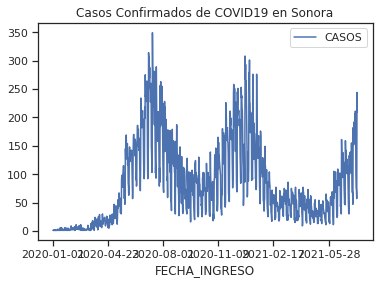

Día con el Mayor Número de Casos Confirmados es el: 2020-07-13 con: 640 caso(s)
Día con el Menor Número de Casos Confirmados es el: 2020-01-01 con: 1 caso(s)
----------------Estimados de Locación----------------
La Media para la entidad seleccionada es: 160.0
La Mediana para la entidad seleccionada es: 119.0
La Media Truncada para la entidad seleccionada es: 143.0
La Desviacion Estandar  para la entidad seleccionada es: 139.8065376118076
----------------Estadisticos de Orden----------------
Valor mínimo: 1
Percentil 10: 7.0
Percentil 25: 45.0
Percentil 50: 119.0
Percentil 75: 243.0
Percentil 90: 370.0
Valor máximo: 640
Asimetria: 0.9452423823869545
Curtosis: 0.19590757509674583
----------------Boxplots----------------


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warni

Ocurrio un error al mostrar el PLOT


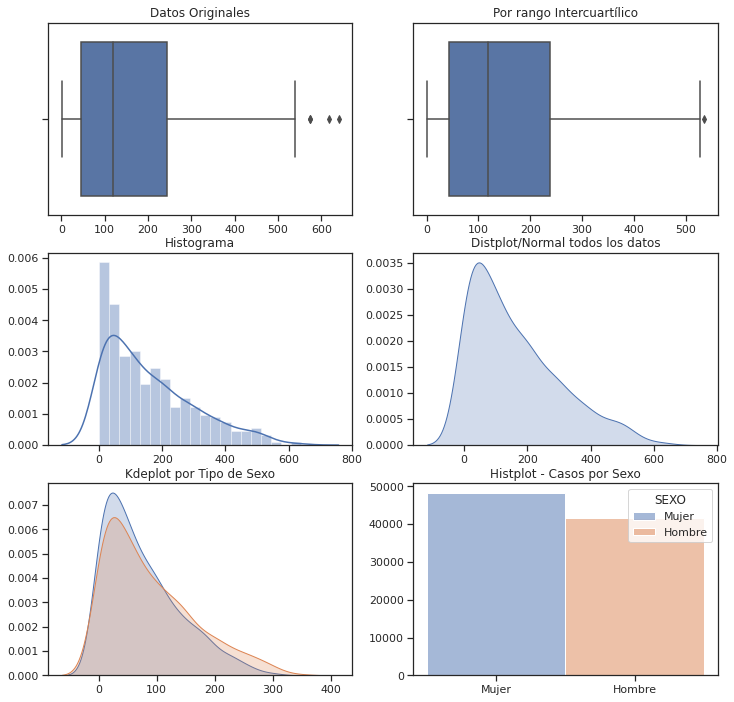

In [23]:
#Obtiene Datos
muestra_info(26) 

In [ ]:
#Generar archivo CSV para Geopandas 
mujeres = casos_x_estado(1)
hombres = casos_x_estado(2)

diccionario_de_rename= {
        'CASOS_x' : 'CASOS_HOMBRES',
        'CASOS_y' : 'CASOS_MUJERES',
        'POBLACION_MUJERES_x' : 'POBLACION_MUJERES',
        'POBLACION_HOMBRES_x' : 'POBLACION_HOMBRES'
}

casos_global = pd.merge(hombres, mujeres, on='ESTADO')
#Renombra columnas
casos_global = casos_global.rename(columns=diccionario_de_rename)

casos_global = casos_global[[ 'ESTADO', 'CASOS_HOMBRES', 'CASOS_MUJERES', 'POBLACION_MUJERES', 'POBLACION_HOMBRES']]

#REPLACE palabras con Acentos
casos_global['ESTADO'] = casos_global['ESTADO'].replace('Michoacán','Michoacan')
casos_global['ESTADO'] = casos_global['ESTADO'].replace('Nuevo León','Nuevo Leon')
casos_global['ESTADO'] = casos_global['ESTADO'].replace('México','Mexico')
casos_global['ESTADO'] = casos_global['ESTADO'].replace('San Luis Potosí','San Luis Potosi')
casos_global['ESTADO'] = casos_global['ESTADO'].replace('Querétaro','Queretaro')
casos_global['ESTADO'] = casos_global['ESTADO'].replace('Yucatán','Yucatan')

casos_global = casos_global.set_index('ESTADO')
casos_global['CASOS_GLOBAL']= casos_global['CASOS_HOMBRES'] +  casos_global['CASOS_MUJERES'] 
casos_global['POBLACION_TOTAL']= casos_global['POBLACION_MUJERES'] +  casos_global['POBLACION_HOMBRES'] 
casos_global['PORCENTAJE']= ( ( casos_global['CASOS_GLOBAL'] /  casos_global['POBLACION_TOTAL'] ) * 100).round(2)
casos_global = casos_global.sort_values(by='ESTADO', ascending=True)
casos_global

,CASOS_HOMBRES,CASOS_MUJERES,POBLACION_MUJERES,POBLACION_HOMBRES,CASOS_GLOBAL,POBLACION_TOTAL,PORCENTAJE
ESTADO,,,,,,,
Aguascalientes,17763,18826,608358,576638,36589,1184996,3.09
Baja California,39802,42668,1563460,1591610,82470,3155070,2.61
Baja California Sur,23604,23540,311593,325433,47144,637026,7.40
Campeche,10151,8128,414720,407721,18279,822441,2.22
Chiapas,26293,27562,2443773,2352807,53855,4796580,1.12
Chihuahua,30611,31512,1713920,1692545,62123,3406465,1.82
Coahuila,39480,41370,1384194,1364197,80850,2748391,2.94
Colima,7713,7673,327765,322790,15386,650555,2.37
Distrito Federal,384746,410043,4617297,4233783,794789,8851080,8.98


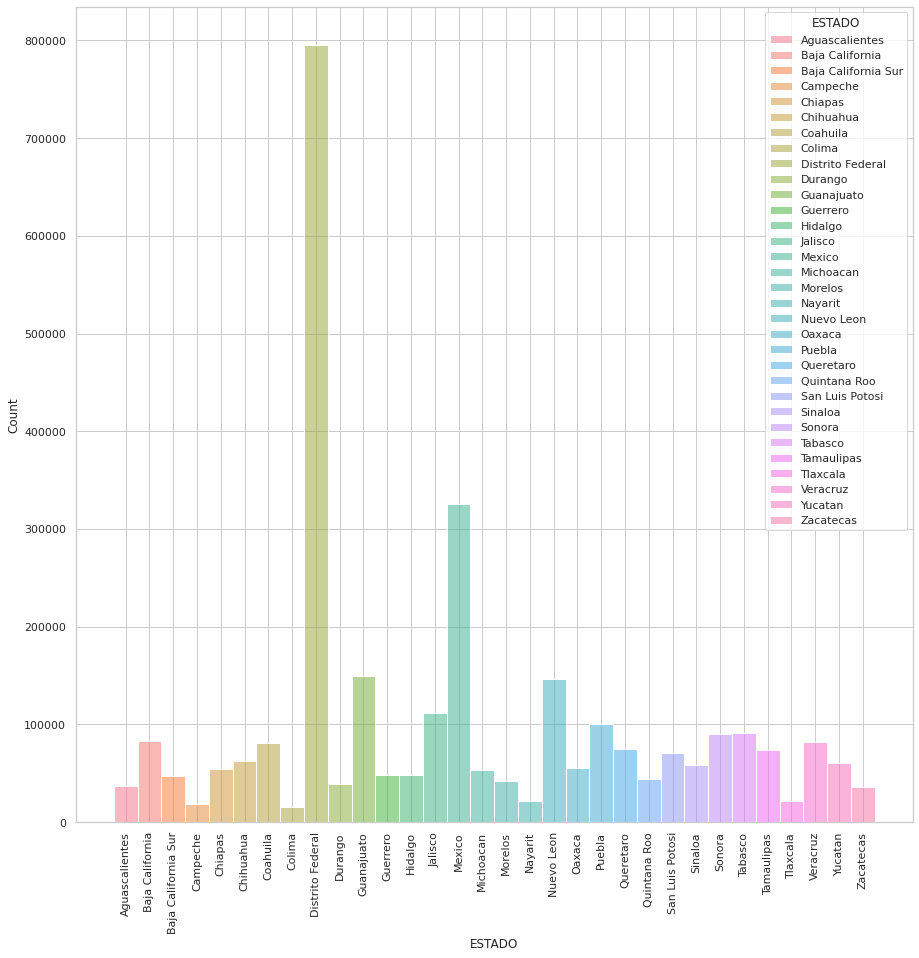

In [ ]:
#casos_global = casos_global.sort_values(by='CASOS_GLOBAL', ascending=False)
fig2 = plt.figure(figsize=(15, 15))
axes = fig2.subplots(1, 1, sharex=False, sharey=False)
sns.histplot(data=casos_global, x='ESTADO', weights='CASOS_GLOBAL', hue = 'ESTADO');
plt.xticks(rotation=90);

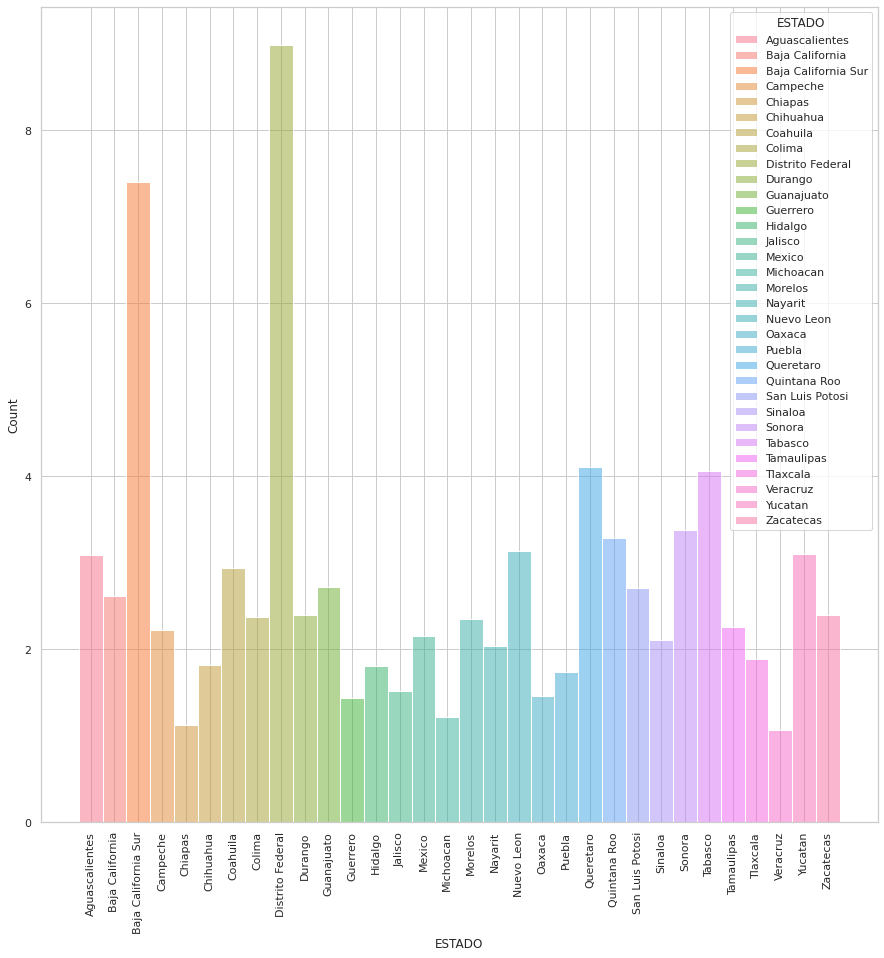

In [ ]:
#casos_global = casos_global.sort_values(by='PORCENTAJE', ascending=False)
fig2 = plt.figure(figsize=(15, 15))
axes = fig2.subplots(1, 1, sharex=False, sharey=False)
sns.histplot(data=casos_global, x='ESTADO', weights='PORCENTAJE', hue = 'ESTADO');
plt.xticks(rotation=90);

In [ ]:
today = date.today()
fecha = str(today.day) + '.' +str(today.month) + '.' + str(today.year)
ruta_csv= '/content/drive/MyDrive/Proyecto BEDU/Pitch/Datos_por_Entidad_'+fecha + '.csv'
casos_global.to_csv(ruta_csv, encoding="utf-8")